## Задание 05 

In [1]:
!pip install ndlib

     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 3.1MB 18.1MB/s 


In [230]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline
import networkx as nx
import pandas as pd
import seaborn as sns

import ndlib.models.epidemics.SIModel as si
import ndlib.models.epidemics.SISModel as sis
import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.ModelConfig as mc

### 1. Влияние топологии на характерное время распространение эпидемии в SI модели.

* Сгенерируйте случайные графы из разных моделей: Эрдеша-Реньи, Барабаши-Альберта, Ваттса-Строгатца. 

Число вершин всех графов $N=10^4$, а средняя степень у всех примерно одинакова и, например, $\left< k\right>\approx10$. 

* Смоделируйте SI модель, изобразите на одном графике среднюю долю инфицированных от времени для разных графов.  

Параметры модели SI - $\beta$ и число шагов по времени - подберите самостоятельно. Усреднение можно проводить по 100 запускам SI (Не по графам!!!).

На этом же графике изобразите кривую, отвечающую приближению среднего поля. 

* Видите ли вы отличия в распространении эпидемии? Объясните результаты. 

In [20]:
N = 10**4
k = 10

from functools import partial 

graphs_generators = {
    'Erdos-Renyi': partial(nx.generators.random_graphs.erdos_renyi_graph, N, k / (N - 1)),
    'Barabasi–Albert': partial(nx.generators.random_graphs.barabasi_albert_graph, N, int(k / 2)),
    'Watts–Strogatz': partial(nx.generators.random_graphs.watts_strogatz_graph, N, int(k / 2), 0.5)
}

In [ ]:
%%time

n_run = 100
n_iter = 120
beta = 0.01

stats = (pd.DataFrame(columns=pd.MultiIndex.from_product([graphs_generators.keys(), ['susceptible', 'infected']])).  
          reindex(pd.MultiIndex.from_product([range(n_run), range(n_iter)], names=["run", "iter"])))
    
for name, generator in graphs_generators.items():
  for i in range(n_run):
    si_model = si(generator()) 
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter("percentage_infected", 0.01)
    si_model.set_initial_status(config)
    iterations = si_model.iteration_bunch(n_iter, False)
    for j, iteration in enumerate(iterations):
      node_count = iteration['node_count']
      stats.loc[(i, j), (name, 'susceptible')] = node_count[0] / N
      stats.loc[(i, j), (name, 'infected')] = node_count[1] / N


In [181]:
stats

Erdos-Renyi          Barabasi–Albert          Watts–Strogatz         
         susceptible infected     susceptible infected    susceptible infected
run iter                                                                      
0   0           0.99     0.01            0.99     0.01           0.99     0.01
    1         0.9891   0.0109           0.989    0.011         0.9895   0.0105
    2         0.9879   0.0121           0.988    0.012          0.989    0.011
    3          0.986    0.014          0.9872   0.0128         0.9888   0.0112
    4         0.9846   0.0154          0.9861   0.0139         0.9886   0.0114
...              ...      ...             ...      ...            ...      ...
99  115       0.0136   0.9864          0.0083   0.9917          0.806    0.194
    116       0.0129   0.9871          0.0081   0.9919         0.8028   0.1972
    117       0.0123   0.9877          0.0078   0.9922         0.7989   0.2011
    118       0.0117   0.9883          0.0075   0.9925         0.7944   0.2056
    119       0.0112   0.9888          0.0073   0.9927         0.7914   0.2086

[12000 rows x 6 columns]

In [224]:
stats = stats.astype(np.float64)
stats.to_csv('stats1.csv')

In [217]:
def si_func(x0, beta, k, t):
    return x0 * np.exp(beta * k * t) / (1 - x0 + x0 * np.exp(beta * k * t))

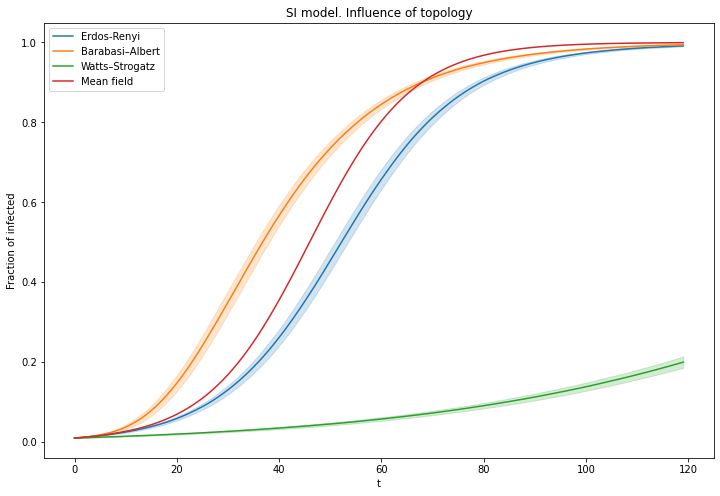

In [278]:
plt.figure(figsize=(12, 8))

t = np.arange(n_iter)

for name in graphs_generators.keys():
  sns.lineplot(x='iter', y=stats.loc[:, (name, 'infected')], 
               data=stats, ci='sd', label=name);

plt.plot(t, si_func(0.01, beta, k, t), label='Mean field')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Fraction of infected')
plt.title('SI model. Influence of topology');

In [350]:
pd.DataFrame({key: max(dict(value().degree).values()) 
for key, value in graphs_generators.items()}, index=['Max degree'])

,Erdos-Renyi,Barabasi–Albert,Watts–Strogatz
Max degree,25,371,10


Быстрее всего эпидемия распространяется в модели Барабаша-Альберта. Медленнее всего - в модели Ваттса-Строгатца. Можно сделать предположение о том, что эпидемия быстрее распространяется в безмасштабных сетях с хабами, а не в сетях относительно однородной топологии.

### 2. Порог зажигания в модели SIS.
Рассмотрим модель SIS с параметром $\mu=1$ на двух графах из задания 1: Эрдеша-Реньи и Барабаши-Альберта. 
Так как $\left< k\right>\approx10$ и $\mu=1$, то пороговое значение $\beta$, выше которого  эпидемия не затухает из приближения среднего поля:
$$
\beta=\frac{1}{\left< k\right>}\approx 0.1,
$$

Постройте зависимость средней доли зараженных в сетях от параметра $\beta$, $\beta \in\left[0,0.2 \right]$. Усреднение проводите по 100 запускам SIS. Число шагов по времени (итераций) определите самостоятельно. 

In [ ]:
%%time
n_iter = 120
n_run = 100
betas = np.linspace(0, 0.2, n_run)

stats1 = (pd.DataFrame(columns=pd.MultiIndex.from_product([['Erdos-Renyi', 'Barabasi–Albert'], ['susceptible', 'infected']])).  
          reindex(pd.MultiIndex.from_product([range(n_run), range(n_iter)], names=["run", "iter"])))

for name in ['Erdos-Renyi', 'Barabasi–Albert']:
  generator = graphs_generators[name]
  for i in range(n_run):
    sis_model = sis(generator()) 
    config = mc.Configuration()
    config.add_model_parameter('beta', betas[i])
    config.add_model_parameter('lambda', 1)
    config.add_model_parameter("percentage_infected", 0.01)
    sis_model.set_initial_status(config)
    iterations = sis_model.iteration_bunch(n_iter, False)
    for j, iteration in enumerate(iterations):
      node_count = iteration['node_count']
      stats1.loc[(i, j), (name, 'susceptible')] = node_count[0] / N
      stats1.loc[(i, j), (name, 'infected')] = node_count[1] / N


In [233]:
stats1 = stats1.astype(np.float64)
stats1.to_csv('stats2.csv')

In [256]:
stats1 = pd.read_csv('stats2.csv', index_col=[0, 1], skiprows=2)
stats1.columns = columns=pd.MultiIndex.from_product([['Erdos-Renyi', 'Barabasi–Albert'], 
                                                     ['susceptible', 'infected']])
stats1

Erdos-Renyi          Barabasi–Albert         
         susceptible infected     susceptible infected
run iter                                              
0   0         0.9900   0.0100          0.9900   0.0100
    1         1.0000   0.0000          1.0000   0.0000
    2         1.0000   0.0000          1.0000   0.0000
    3         1.0000   0.0000          1.0000   0.0000
    4         1.0000   0.0000          1.0000   0.0000
...              ...      ...             ...      ...
99  115       0.6457   0.3543          0.6680   0.3320
    116       0.6502   0.3498          0.6608   0.3392
    117       0.6468   0.3532          0.6637   0.3363
    118       0.6407   0.3593          0.6630   0.3370
    119       0.6434   0.3566          0.6683   0.3317

[12000 rows x 4 columns]

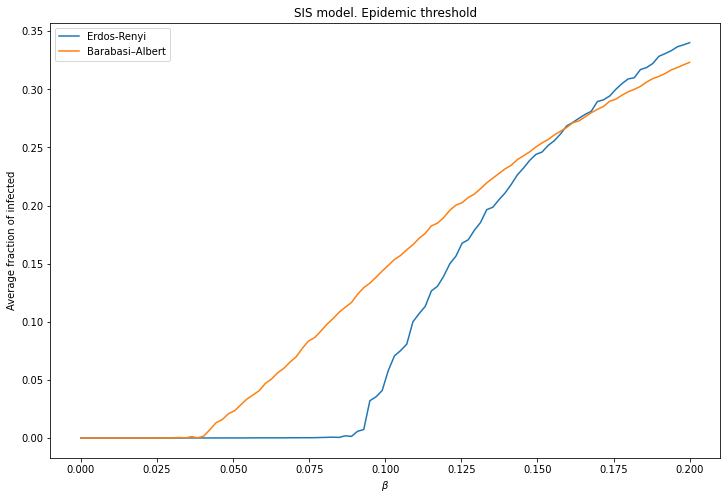

In [280]:
plt.figure(figsize=(12, 8))

for name in ['Erdos-Renyi', 'Barabasi–Albert']:
  sns.lineplot(x=betas, y=stats1.groupby('run').mean().loc[:, (name, 'infected')], label=name);

plt.title('SIS model. Epidemic threshold')
plt.xlabel(r'$\beta$')
plt.ylabel('Average fraction of infected');

Видим, что порог зажигания в модели Барабаша-Альберта сильно смещен влево.

### 3. Влияние топологии в модели SIR.
Рассмотрим модель SIR на следующих сетях: 

In [282]:
G1=nx.read_graphml('graph1.graphml')
G2=nx.read_graphml('graph2.graphml')

* Постройте зависимости средней доли зараженных вершин в модели SIR для первого и второго графа.

Параметры для моделирования:

In [292]:
beta=0.005
gamma=0.03
percentage_infected=0.002
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

stats2 = (pd.DataFrame(columns=pd.MultiIndex.from_product([['G1', 'G2'], ['susceptible', 'infected']])).  
          reindex(pd.MultiIndex.from_product([range(n_run), range(n_iter)], names=["run", "iter"])))

for k, G in enumerate((G1, G2)):
  for i in range(n_run):
    sir_model = sir(G) 
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("percentage_infected", percentage_infected)
    sir_model.set_initial_status(config)
    iterations = sir_model.iteration_bunch(n_iter, False)
    for j, iteration in enumerate(iterations):
      node_count = iteration['node_count']
      stats2.loc[(i, j), ('G' + str(k + 1), 'susceptible')] = node_count[0] / N
      stats2.loc[(i, j), ('G' + str(k + 1), 'infected')] = node_count[1] / N

100%|██████████| 200/200 [00:00<00:00, 440.31it/s]


In [296]:
stats2 = stats2.astype(np.float64)
stats2

G1                   G2         
         susceptible infected susceptible infected
run iter                                          
0   0         0.0749   0.0001      0.0749   0.0001
    1         0.0749   0.0001      0.0748   0.0002
    2         0.0749   0.0001      0.0746   0.0004
    3         0.0749   0.0001      0.0746   0.0004
    4         0.0749   0.0001      0.0744   0.0006
...              ...      ...         ...      ...
99  195       0.0000   0.0007      0.0000   0.0001
    196       0.0000   0.0007      0.0000   0.0001
    197       0.0000   0.0007      0.0000   0.0001
    198       0.0000   0.0007      0.0000   0.0001
    199       0.0000   0.0007      0.0000   0.0001

[20000 rows x 4 columns]

In [297]:
stats2.to_csv('stats3.csv')

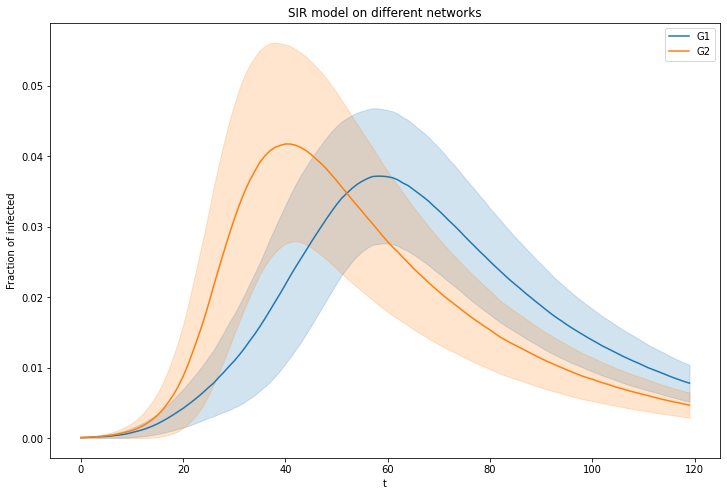

In [298]:
plt.figure(figsize=(12, 8))

t = np.arange(n_iter)

for name in ('G1', 'G2'):
  sns.lineplot(x='iter', y=stats2.loc[:, (name, 'infected')], 
               data=stats, ci='sd', label=name);

plt.xlabel('t')
plt.ylabel('Fraction of infected')
plt.title('SIR model on different networks');

* Отличаются ли построенные зависимости? 
Попробуйте понять, что влияет на распространение в сети, для этого исследуйте топологию G1, G2. 

Видим, что пик заражения на сети G2 смещён влево. Исследуем топологию:

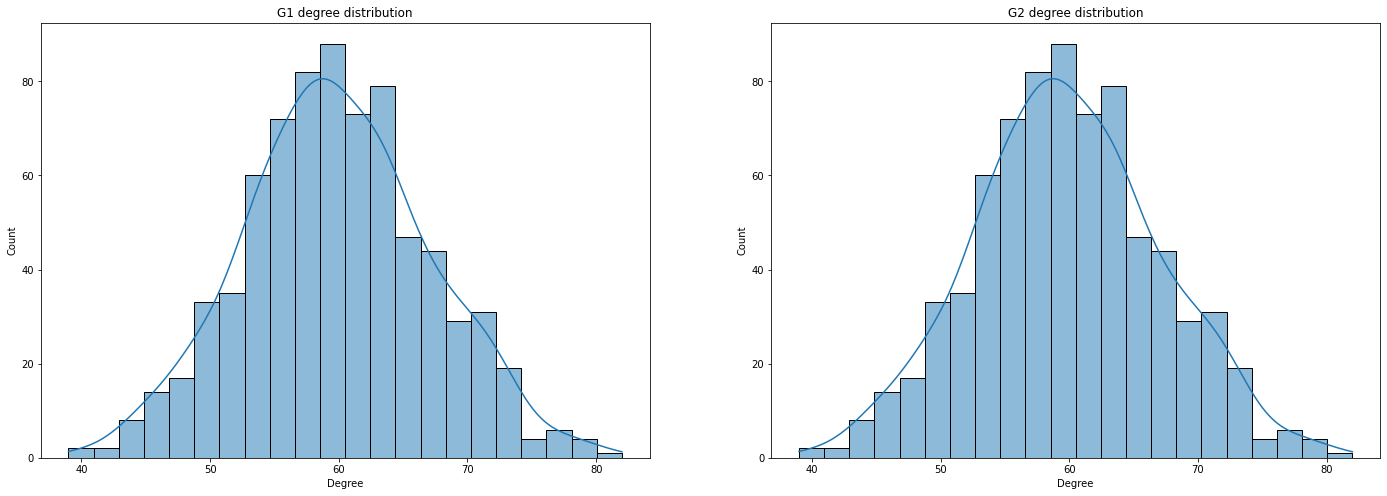

In [345]:
plt.figure(figsize=(24, 8))

plt.subplot(121)
sns.histplot(x=dict(G1.degree).values(), kde=True)
plt.xlabel('Degree')
plt.title('G1 degree distribution')

plt.subplot(122)
sns.histplot(x=dict(G2.degree).values(), kde=True)
plt.xlabel('Degree')
plt.title('G2 degree distribution');

Распределения степеней абсолютно одинаковые. Взглянем на кластеризацию:

In [346]:
pd.DataFrame({'G1': (nx.algorithms.cluster.average_clustering(G1), nx.average_shortest_path_length(G1)),
              'G2': (nx.algorithms.cluster.average_clustering(G2), nx.average_shortest_path_length(G2))}, 
             index=['Average clustering', 'Average shortest path length'])

,G1,G2
Average clustering,0.711991,0.079916
Average shortest path length,2.665915,1.927847


Видим, что ср. кластеризация сети G1 >> ср. кластеризации G2, за счет чего сеть G1 в большей степени обладает свойствами "тесного мира". Можно сделать предположением о том, что эпидемия распространяется медленнее в "тесных мирах".